Métodos directos estocasticos
===

* 30:00 min | Última modificación: Mayo 19, 2021 | [YouTube]

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np

In [2]:
#
# Función de Rosenbrock
#
def fn(x):
    return 100 * (x[0] ** 2 - x[1]) ** 2 + (1 - x[0]) ** 2

## Clase base

In [3]:
class BaseOptimizer:
    def __init__(self, fn):
        self.fn = fn
        self.x_opt = None
        self.fn_opt = None
        self.n_dim = None
        self.history = {
            "fn_opt": [],
            "x_opt": [],
            "x": [],
            "fn_x": [],
        }

    def record(self, x, fn_x):
        self.history["x"].append(x)
        self.history["fn_x"].append(fn_x)

    def eval(self, x):
        fn_x = self.fn(x)
        if self.fn_opt is None or fn_x < self.fn_opt:
            self.fn_opt = fn_x
            self.x_opt = x
            self.n_dim = len(x)
            self.history["x"].append(x)
            self.history["fn_x"].append(fn_x)
            self.history["x_opt"].append(x)
            self.history["fn_opt"].append(fn_x)
        return fn_x

    def random_direction(self):
        w = np.random.uniform(low=-1, high=+1, size=self.n_dim)
        m = np.linalg.norm(w)
        return w / m

## Funciones auxiliares

In [4]:
def plot_trayectory(optimizer):
    #
    # Función
    #
    def f(x, y):
        return 100 * (x ** 2 - y) ** 2 + (1 - x) ** 2

    #
    X = np.linspace(start=-2.048, stop=2.048, num=100)
    Y = np.linspace(start=-0.1, stop=4.0, num=100)
    X, Y = np.meshgrid(X, Y)
    Z = f(X, Y)

    #
    # Contorno
    #
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal", "box")
    ax.contour(X, Y, Z, colors="gray")
    ax.grid()
    plt.plot([1], [1], "o", color="red")

    #
    # Trayectoria
    #
    hist_x = optimizer.history["x"]
    x = [point[0] for point in hist_x]
    y = [point[1] for point in hist_x]
    plt.plot(x, y, "o-", color="k")


In [5]:
def plot_fn(optimizer):
    plt.figure(figsize=(8, 4))
    plt.plot(
        range(len(optimizer.history["fn_opt"])),
        optimizer.history["fn_opt"],
        "o-k",
    )
    plt.show()


## Quimiotaxismo Bacterial

In [6]:
class BacterialChemotaxis(BaseOptimizer):
    #
    # Propuesto por Muller, Airgahi, Marchetto y Koumoustsakos
    # en el año 2000. Es un algoritmo de búsqueda local 
    # elitista. Se base en la imitación de como las bacterias
    # son atraidas a los mejores ambientes (a nivel macro)
    # y con el comportamiento de las colonias a nivel micro.
    #
    def __init__(self, fn, rho=0.5):
        super().__init__(fn=fn)
        #
        # tamaño del avance
        #
        self.rho = rho

    def __call__(self, x, fn_x=None):

        if fn_x is None:
            fn_x = self.eval(x)

        x_base = x.copy()
        fn_x_base = self.eval(x_base)

        while True:
            #
            # Genera un vector con dirección aleatoria
            # y radio rho
            #
            v = self.rho * self.random_direction()
            
            #
            # Avanza en la dirección aleatoria
            #
            x = x_base + v
            fn_x = self.eval(x)

            #
            # Si fn mejora, se acepta el nuevo punto
            # como la nueva base, haciendo que se avance
            # en la dirección encontrada
            #
            if fn_x < fn_x_base:
                x_base = x
                fn_x_base = fn_x
            else:
                break

        return self.x_opt, self.fn_opt


optimizer = BacterialChemotaxis(
    fn=fn,
    rho=0.1,
)

#
# Punto inicial
#
x = np.asarray([-1.0, 3.5], dtype=np.float32)
fx = None

for epoch in range(100):
    x, fx = optimizer(x, fx)

optimizer.x_opt, optimizer.fn_opt

(array([-1.85179396,  3.4336457 ]), 8.134758148409558)

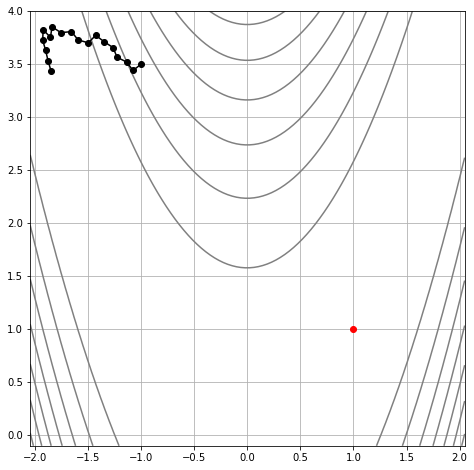

In [7]:
plot_trayectory(optimizer)

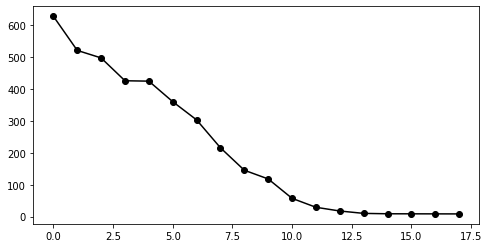

In [8]:
plot_fn(optimizer)

## Temple Simulado

In [9]:
class SimulatedAnnealing(BaseOptimizer):
    def __init__(self, fn, t_init=0.5, t_min=0.001, M=1000):
        super().__init__(fn=fn)
        #
        self.t_init = t_init
        self.t_min = t_min
        self.M = M
        #
        self.t_current = None
        self.factor = None
        #

    def __call__(self, x, fn_x=None):

        if fn_x is None:
            fn_x = self.eval(x)

        if self.t_current is None:
            self.t_current = self.t_init

        if self.factor is None:
            self.factor = np.power(self.t_min / self.t_init, 1.0 / self.M)

        v = self.random_direction()
        x_next = x + np.random.uniform() * self.t_current * v
        fn_x_next = self.eval(x_next)

        if np.random.uniform() < 1 / (
            1 + np.exp(max(-50, min(50, (fn_x_next - fn_x) / self.t_current)))
        ):
            x = x_next
            fn_x = fn_x_next

        self.t_current = max(self.t_min, self.factor * self.t_current)

        return x, fn_x


optimizer = SimulatedAnnealing(
    fn=fn,
)

#
# Punto inicial
#
x = np.asarray([-1.0, 3.5], dtype=np.float32)
fx = None

for epoch in range(25):
    x, fx = optimizer(x, fx)

optimizer.x_opt, optimizer.fn_opt

(array([-1.95573008,  3.58554586]), 14.464430953826975)

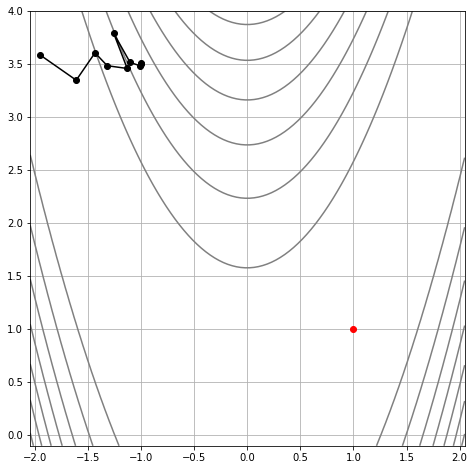

In [10]:
plot_trayectory(optimizer)

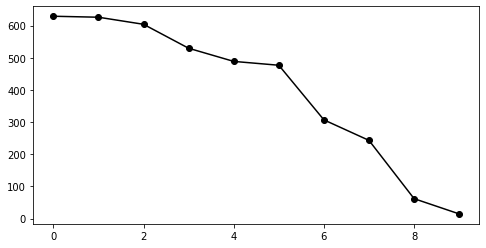

In [11]:
plot_fn(optimizer)

## Threshold Acceptance

In [12]:
class ThresholdAcceptance(BaseOptimizer):
    def __init__(self, fn, threshold=1, R=1.0, M=100):
        super().__init__(fn=fn)
        self.threshold = threshold
        self.R = R
        self.M = M
        self.factor = None

    def __call__(self, x, fn_x=None):

        if fn_x is None:
            fn_x = self.eval(x)

        if self.factor is None:
            self.factor = math.pow(1e-6 / self.threshold, 1.0 / self.M)

        v = self.random_direction()
        x_next = x + np.random.uniform() * self.R * v
        fn_x_next = self.eval(x_next)

        if (fn_x_next - fn_x) <= self.threshold:
            x = x_next
            fn_x = fn_x_next
            self.threshold = self.threshold * self.factor

        return x, fn_x


optimizer = ThresholdAcceptance(
    fn=fn,
)

#
# Punto inicial
#
x = np.asarray([-1.0, 3.5], dtype=np.float32)
fx = None

for epoch in range(20):
    x, fx = optimizer(x, fx)

optimizer.x_opt, optimizer.fn_opt

(array([-1.77726838,  3.19324278]), 7.832658280359617)

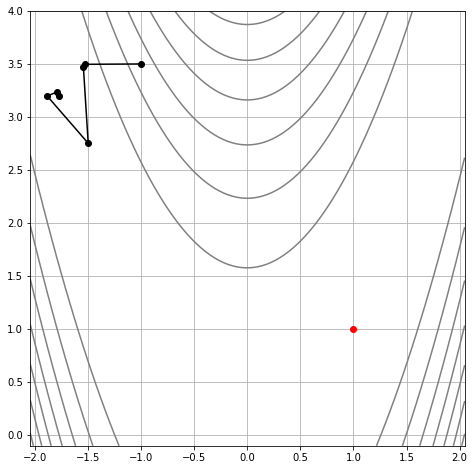

In [13]:
plot_trayectory(optimizer)

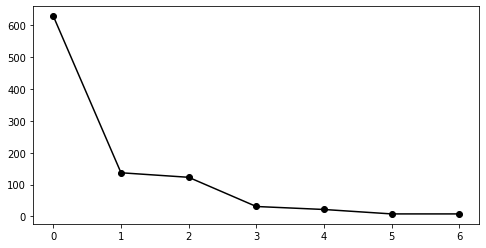

In [14]:
plot_fn(optimizer)

## Estrategias de Evolución "1+1" y "1,1"

In [15]:
class EvolutionStrategies11(BaseOptimizer):
    #
    # Desarrollado por Rechenberg y Schwefel en los años 60,
    # en la Universidad Técnica de Berlin. La versión 1+1 es
    # un algoritmo de búsqueda local elitista.
    #
    def __init__(self, fn, sigma_init=0.1, sigma_min=0.001, plus=True):

        super().__init__(fn=fn)

        self.sigma_init = sigma_init
        self.sigma_min = sigma_min
        self.plus = plus
        self.sigma = None
        #

    def __call__(self, x, fn_x=None):

        if fn_x is None:
            fn_x = self.eval(x)

        #
        # sigma es la desviación estándar de la mutación
        #
        if self.sigma is None:
            self.sigma = self.sigma_init

        #
        # muta el sigma actual
        #
        Nt = np.random.normal()
        sigma_next = self.sigma * np.exp(
            0.5 * np.random.normal(size=self.n_dim) + Nt / (2 * math.sqrt(2))
        )
        #
        # El sigma no puede ser inferior a un valor límite
        #
        sigma_next = np.where(sigma_next < self.sigma_min, self.sigma_min, sigma_next)
        
        #
        # El siguiente punto se obtiene como el punto actual
        # más un aleatorio que representa una mutación
        #
        x_next = x + sigma_next * np.random.normal(size=self.n_dim)

        fn_x = self.eval(x)
        fn_x_next = self.eval(x_next)

        if self.plus is False or (self.plus is True and fn_x_next < fn_x):
            x = x_next
            self.sigma = sigma_next

        return x, fn_x


optimizer = EvolutionStrategies11(
    fn=fn,
    plus=True,
)

#
# Punto inicial
#
x = np.asarray([-1.0, 3.5], dtype=np.float32)
fx = None

for epoch in range(50):
    x, fx = optimizer(x, fx)

optimizer.x_opt, optimizer.fn_opt

(array([-0.86371633,  0.72721799]), 3.508737066487657)

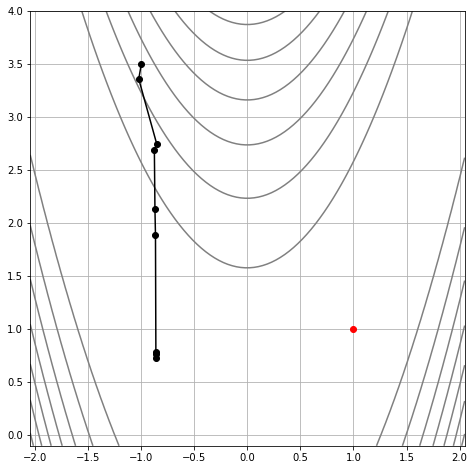

In [16]:
plot_trayectory(optimizer)

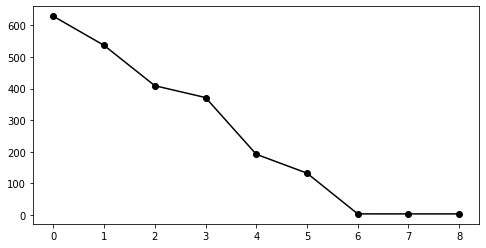

In [17]:
plot_fn(optimizer)

In [18]:
optimizer = EvolutionStrategies11(
    fn=fn,
    plus=False,
)

#
# Punto inicial
#
x = np.asarray([-1.0, 3.5], dtype=np.float32)
fx = None

for epoch in range(500):
    x, fx = optimizer(x, fx)

optimizer.x_opt, optimizer.fn_opt

(array([-0.71796278,  0.66603675]), 5.218414054928819)

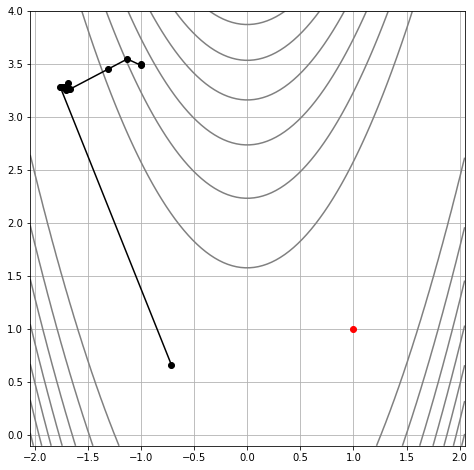

In [19]:
plot_trayectory(optimizer)

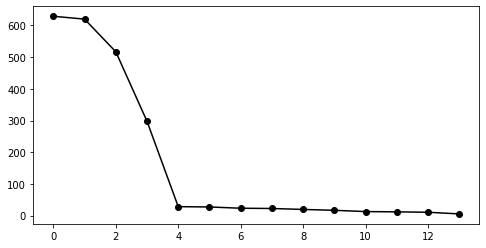

In [20]:
plot_fn(optimizer)

## Programación Evolutiva 1,1

In [21]:
class EvolutionaryProgramming11(BaseOptimizer):
    #
    # Desarrollado por Fogel y Lawrence en los 60s, usando
    # la adaptación a un medio como inteligencia
    #
    def __init__(self, fn, alpha=0.001, beta=0.1):

        super().__init__(fn=fn)
        self.alpha = alpha
        self.beta = beta
        #
        self.N = None

    def __call__(self, x, fn_x=None):

        if fn_x is None:
            fn_x = self.eval(x)

        delta = math.sqrt(self.alpha * fn_x + self.beta) * np.random.normal(size=self.n_dim)
        x_next = delta
        fn_x_next = self.eval(x_next)

        if fn_x_next < fn_x:
            x = x_next
            fn_x = fn_x_next

        return x, fn_x


optimizer = EvolutionaryProgramming11(
    fn=fn,
)

#
# Punto inicial
#
x = np.asarray([-1.0, 3.5], dtype=np.float32)
fx = None

for epoch in range(30):
    x, fx = optimizer(x, fx)

optimizer.x_opt, optimizer.fn_opt

(array([0.4334169 , 0.18218846]), 0.3242219517148337)

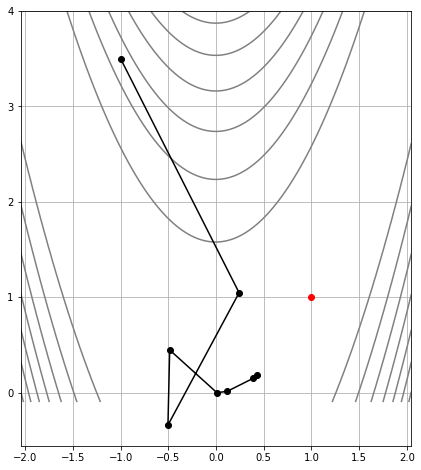

In [22]:
plot_trayectory(optimizer)

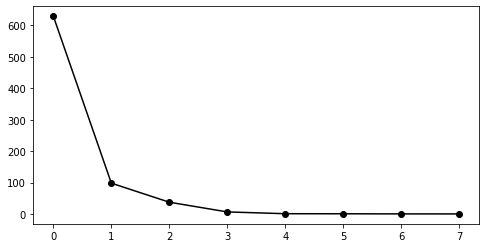

In [23]:
plot_fn(optimizer)